In [6]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal

In [3]:
%config InlineBackend.figure_format = "retina"

In [29]:
def sigmoid(x): return jnp.exp(x) / (1 + jnp.exp(x))

def neg_log_likelihood(w, Phi, y):
    y = 2 * y.ravel() - 1
    an = jnp.einsum("nm,m->n", Phi, w)
    nll = jnp.log1p(jnp.exp(-y * an)).mean()
    return -nll

## The data

In [30]:
np.random.seed(135)
# Creating data
N = 30
D = 2
mu1 = np.array([1, 5])
mu2 = np.array([-5, 1])
std1 = 1
std2 = 2.2
X1 = std1 * np.random.randn(N,2) +  mu1
X2 = std2 * np.random.randn(N,2) +  mu2
X = np.r_[X1, X2]
t = np.r_[np.ones(N), np.zeros(N)][:, None]

In [192]:
domain = 8
step = 0.1
Xgrid = np.mgrid[-domain:domain:step, -domain:domain:step]
ws = np.array([[3, 1], [4, 2], [5, 3], [7, 3]])

In [193]:
Wgrid = Xgrid.copy()

In [194]:
nll_vmap = jax.vmap(neg_log_likelihood, (1, None, None))
nll_vmap = jax.vmap(nll_vmap, (2, None, None))

## Log-likelihood

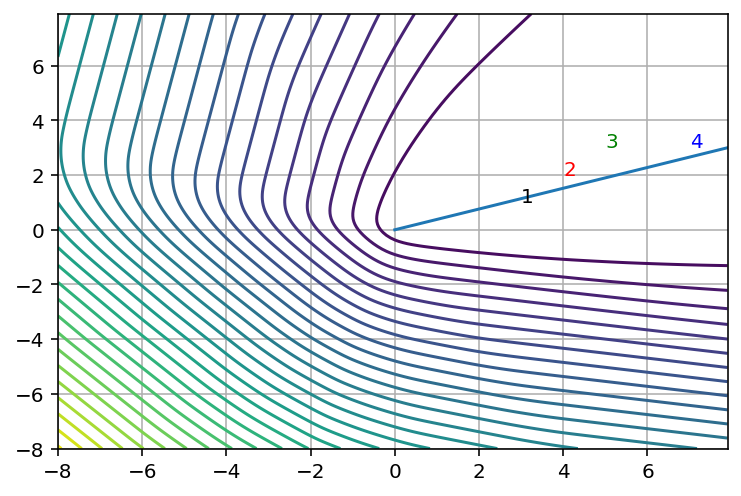

In [135]:
an = jnp.einsum("mij,nm->nij", Wgrid, X)
cst = jnp.einsum("mij,nm,nk->ij", Wgrid, X, t)

ll_grid = cst - jnp.log1p(jnp.exp(an)).sum(axis=0)
plt.contour(*Wgrid, -ll_grid, 30)

colors = ["black", "red", "green", "blue"]
for i, (wi, color) in enumerate(zip(ws, colors)):
    plt.annotate(str(i+1), xy=wi, color=color)

ix0, ix1 = jnp.where(ll_grid == ll_grid.max())
w_mle = Wgrid[:, ix0, ix1].ravel()

slope = w_mle[1] / w_mle[0]
plt.plot([0, 7.9], [0, 7.9*slope])
plt.grid()

## Log-posterior unnormalized 

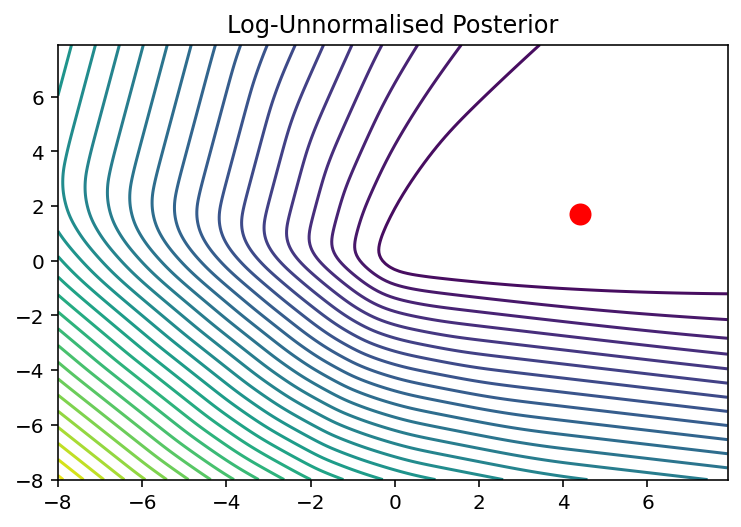

In [311]:
alpha = 100
mu0 = jnp.zeros(D)
Sigma0 = jnp.eye(D) * alpha

prior_logpdf = lambda w: multivariate_normal.logpdf(w, mu0, Sigma0)
prior_logpdf = jax.vmap(prior_logpdf, 1)
prior_logpdf = jax.vmap(prior_logpdf, 2)

prior_logpdf_grid = prior_logpdf(Wgrid)
log_joint_grid = prior_logpdf_grid + ll_grid

plt.contour(*Wgrid, -log_joint_grid, 30)
plt.title("Log-Unnormalised Posterior")

ix0, ix1 = jnp.where(log_joint_grid == log_joint_grid.max())
w_best = Wgrid[:, ix0, ix1].ravel()

plt.scatter(*w_best, c="red", s=100)

## Laplace approximation to posterior

In [312]:
from jax.scipy.optimize import minimize

In [313]:
def sigmoid(x): return jnp.exp(x) / (1 + jnp.exp(x))
def log_sigmoid(z): return z - jnp.log1p(jnp.exp(z))

def E_base(w, Phi, y, alpha):
    """
    Base function containing the Energy of a logistic
    regression with. Energy log-joint
    """
    y = y.ravel() * 2 - 1
    an = Phi @ w
    log_an = log_sigmoid(an)
    log_likelihood_terms = jnp.log1p(jnp.exp(-y * an)).mean()
    log_prior_term = alpha * w @ w / 2

    return log_prior_term + log_likelihood_terms

In [378]:
key = jax.random.PRNGKey(314)
alpha = 1/1500
init_noise = 1.0
w0 = jnp.zeros(D)

E = lambda w: E_base(w, X, t, alpha) / len(t)
res = minimize(E, w0, method="BFGS", options={"maxiter":100})
w_laplace = res.x
SN = jax.hessian(E)(w_laplace)
# SN = jnp.linalg.inv(SN)

In [379]:
posterior_logpdf = lambda w: multivariate_normal.logpdf(w, w_laplace, SN)
posterior_logpdf = jax.vmap(posterior_logpdf, 1)
posterior_logpdf = jax.vmap(posterior_logpdf, 2)

Text(0.5, 1.0, 'Laplace Approximation to Posterior')

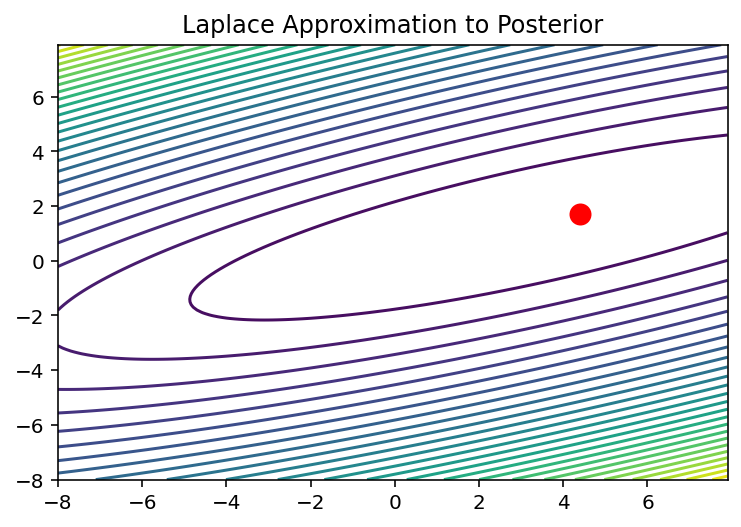

In [389]:
meanv = (Wgrid - w_laplace[:, None, None])
logpdf = jnp.einsum("mij,mn,nij->ij", meanv, SN, meanv)
plt.contour(*Wgrid, logpdf, 30)
plt.scatter(*w_best, c="red", s=100)
plt.title("Laplace Approximation to Posterior")